In [1]:
import rampy as rp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime
import os

from pydantic import BaseModel
from typing import List

import matplotlib.dates as mdates
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from scipy.signal import savgol_filter

In [2]:
class XRange(BaseModel):
    lower_limit:float
    higher_limit:float

def _select_range(x_range:XRange, data:np.array) -> np.array:
    cond1 = data[:,0] > x_range.lower_limit
    cond2 = data[:,0] < x_range.higher_limit
    cond = cond1 & cond2
    data = data[cond].copy()
    return data

def load_data(filename:str, x_range:XRange=None,  basepath:str="./data") -> np.array:
    # from glob import glob
    import os
    filepath = os.path.join(basepath, f"{filename}")
    if(os.path.exists(filepath) == False):
        raise FileExistsError(f"{filepath=} is not exists")
    spectrum = np.genfromtxt(filepath)
    # Flip X-axis
    spectrum = rp.flipsp(spectrum)
    if(x_range != None):
        assert isinstance(x_range, XRange), f"limit_x must be `XRange`"
        spectrum = _select_range(x_range=x_range, data=spectrum)
    return spectrum

## OGTT result

Let's plot how the OGTT went for s1, s2, s3, and s4

In [3]:
subj_ids = ['s1','s2','s3','s4','s5','s6','s7','s8']
datas = []

basepath = "../../data/pilot"
for subj_id in subj_ids:
    filepath = os.path.join(basepath, f"{subj_id}.csv")
    if(os.path.exists(filepath) == False):
        raise FileExistsError(f"{filepath=} is not found")
    df = pd.read_csv(filepath,parse_dates=['time'], dtype={'glucose':'float',
                                    'prefix':'string'},index_col="time")
    datas.append(df)
    del(df)


In [4]:
today = datetime.today().replace(hour=1, minute=0, second=0, microsecond=0)

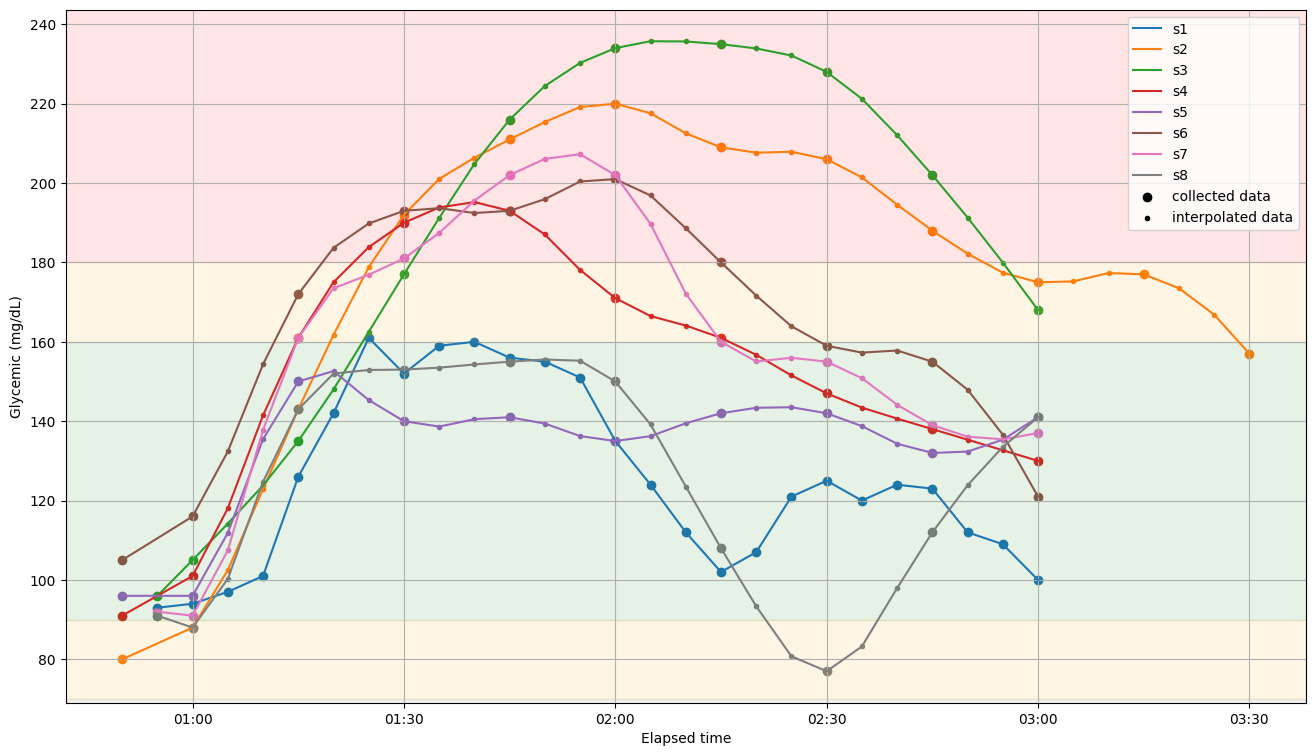

In [5]:
fig, ax = plt.subplots(figsize=(16,9))
color_list = list(colors.TABLEAU_COLORS.values())
glucoses = []
for index, (subj_id, data) in enumerate(zip(subj_ids, datas)):
    y = data.glucose
    x = y.index
    y = y.interpolate(method='polynomial', order=2)
    glucoses += list(y)
    elapse = x - x[1]
    ax.scatter(elapse + today, y, c=color_list[index], marker='.')
    ax.scatter(elapse + today, data.glucose, c=color_list[index])
    ax.plot(elapse + today, y, label=subj_id, color=color_list[index])
    # Update the interpolated data
    data.glucose = y

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.scatter(0,0, marker='o', label='collected data', c='black')
ax.scatter(0,0, marker='.', label='interpolated data', c='black')
# ax.set_title("A result of OGTT of 8 participants with polynomial interpolation")
ax.set_xlabel("Elapsed time")
ax.set_ylabel("Glycemic (mg/dL)")
axisx_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(axisx_format)
ax.axhspan(60,70, color='grey', alpha=0.1)
ax.axhspan(70,90, color='orange', alpha=0.1)
ax.axhspan(90,160, color='green', alpha=0.1)
ax.axhspan(160,180, color='orange', alpha=0.1)
ax.axhspan(180,250, color='red', alpha=0.1)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend()
ax.grid()
plt.show()

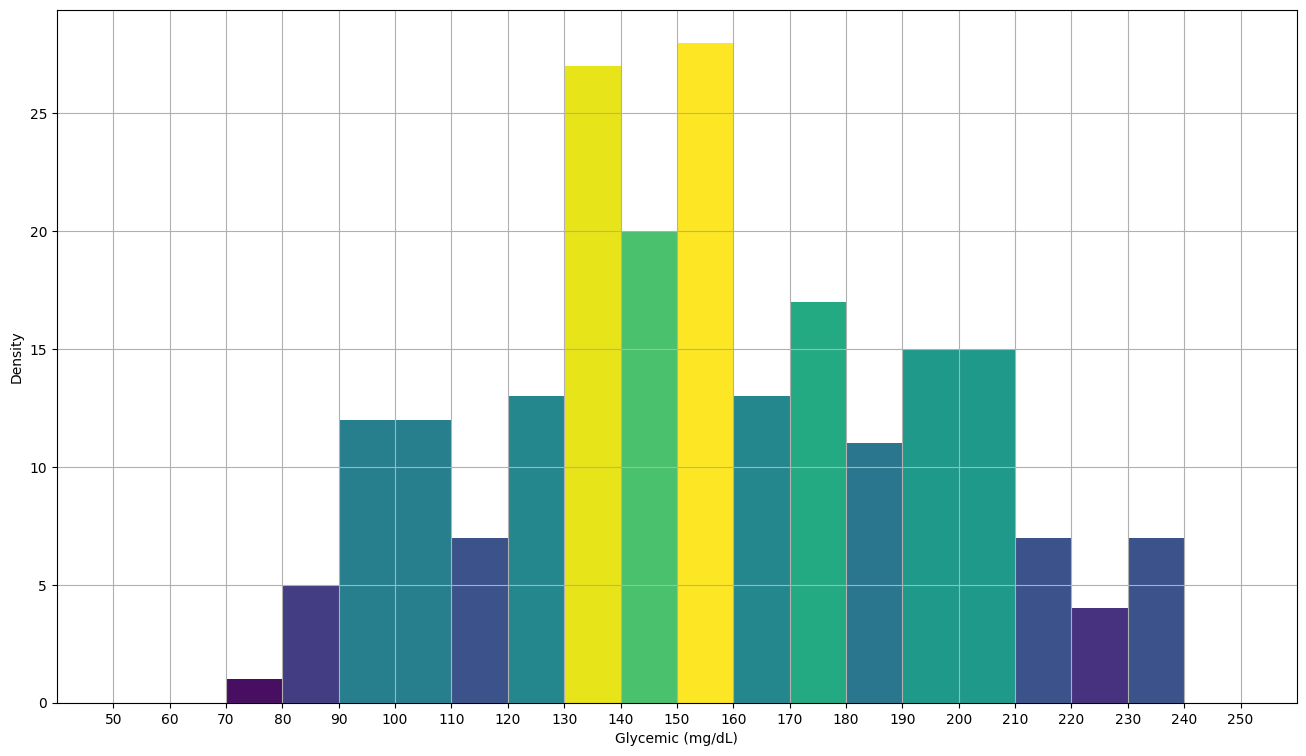

In [6]:
fig, ax = plt.subplots(figsize=(16,9))
bins = range(50,251,10)
N, bins, patches = ax.hist(x=glucoses, bins=bins)
# We'll color code by height, but you could use any scalar
fracs = N / N.max()
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# ax.set_title("Glycemic distribution from 8 participants")
ax.set_xlabel("Glycemic (mg/dL)")
ax.set_ylabel("Density")
ax.set_xticks(ticks=bins)
# ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
# ax.axhspan(60,70, color='grey', alpha=0.1)
# ax.axhspan(70,90, color='orange', alpha=0.1)
# ax.axhspan(90,160, color='green', alpha=0.1)
# ax.axhspan(160,180, color='orange', alpha=0.1)
# ax.axhspan(180,250, color='red', alpha=0.1)
# ax.legend()
ax.grid()
plt.show()

## Raman Measurement

In [7]:
def lower_thres(point:float, ratio:float) -> float:
    sign = np.sign(point)
    mag = abs(point)
    point = sign * (mag - (sign * (mag * ratio)))
    return point

def higher_thres(point:float, ratio:float) -> float:
    sign = np.sign(point)
    mag = abs(point)
    point = sign * (mag + (sign * (mag * ratio)))
    return point

def standardized(data:np.array) -> np.array:
    assert data.ndim == 1
    x = data.copy()
    # x_i = x_i - mean / std
    mean = x.mean()
    std = x.std()
    # print(mean, std)
    x = (x - mean)/std
    return x

def normalization(data:np.array) -> np.array:
    assert data.ndim == 1
    x = data.copy()
    min = x.min()
    max = x.max()
    x = (x - min)/(max - min)
    return x
# normalization(y)

def butter_lowpass_filter(data:np.array, normal_cutoff:float, order:int=1):
    from scipy.signal import butter,filtfilt
    y = data.copy()
    # normal_cutoff = cutoff / (fs * 0.5)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, y)
    return y

def butter_highpass_filter(data:np.array, normal_cutoff:float, order:int=1):
    from scipy.signal import butter,filtfilt
    y = data.copy()
    # normal_cutoff = cutoff / (fs * 0.5)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, y)
    return y

def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores

# The next function calculates the average values around the point to be replaced.
def despike(y:np.array,window_size:int=20) -> np.array:
    ma = window_size//2
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    # print(spikes.any())
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            y_out[i] = np.mean(y[we])
    return y_out


In [8]:
x_range = XRange(lower_limit=600, higher_limit=1500)

# Load data into the column of df
for subj_id,data in zip(subj_ids, datas):
    spectrums = []
    for prefix in data.prefix:
        # Look for a file with this prefix
        file_lookup = os.path.join(basepath,subj_id,f"{prefix}_*")
        lookup_result = sorted(glob(file_lookup))
        assert len(lookup_result) != 0, f"{file_lookup=}, {lookup_result=}"
        # select the latest one
        filepath = lookup_result[-1]
        spectrum = load_data(filename=filepath, x_range=x_range, basepath="")
        spectrums.append(spectrum)
    data['spectrum'] = spectrums


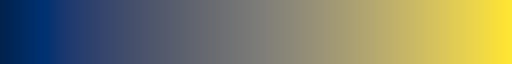

In [9]:
import peakutils.baseline as baseline
from matplotlib import colormaps, cm
cNorm = colors.Normalize(vmin=min(glucoses), vmax=max(glucoses))
cMap = cm.ScalarMappable(norm=cNorm, cmap=colormaps['cividis'])
colormaps['cividis']

In [10]:
def preprocessing_1(y:np.array) -> np.array:
    y = despike(y, window_size=25)
    y = standardized(y)
    bl = baseline(y, deg=4)
    y = y - bl
    y = butter_lowpass_filter(data=y, normal_cutoff=0.1, order=2)
    return y

def preprocessing_2(y:np.array) -> np.array:
    y = despike(y, window_size=25)
    y = butter_lowpass_filter(data=y, normal_cutoff=0.1, order=2)
    y = np.gradient(y, edge_order=1)
    y = butter_lowpass_filter(data=y, normal_cutoff=0.1, order=2)
    return y

def preprocessing_3(y:np.array) -> np.array:
    y = despike(y, window_size=25)
    y = butter_highpass_filter(data=y, normal_cutoff=0.01, order=1)
    y = butter_lowpass_filter(data=y, normal_cutoff=0.1, order=1)
    # y = butter_highpass_filter(data=y, normal_cutoff=0.01, order=1)
    return y

def preprocessing_4(y:np.array) -> np.array:
    y = despike(y, window_size=25)
    y = standardized(y)
    # bl = baseline(y, deg=4)
    # y = y - bl
    y = butter_lowpass_filter(data=y, normal_cutoff=0.1, order=2)
    return y



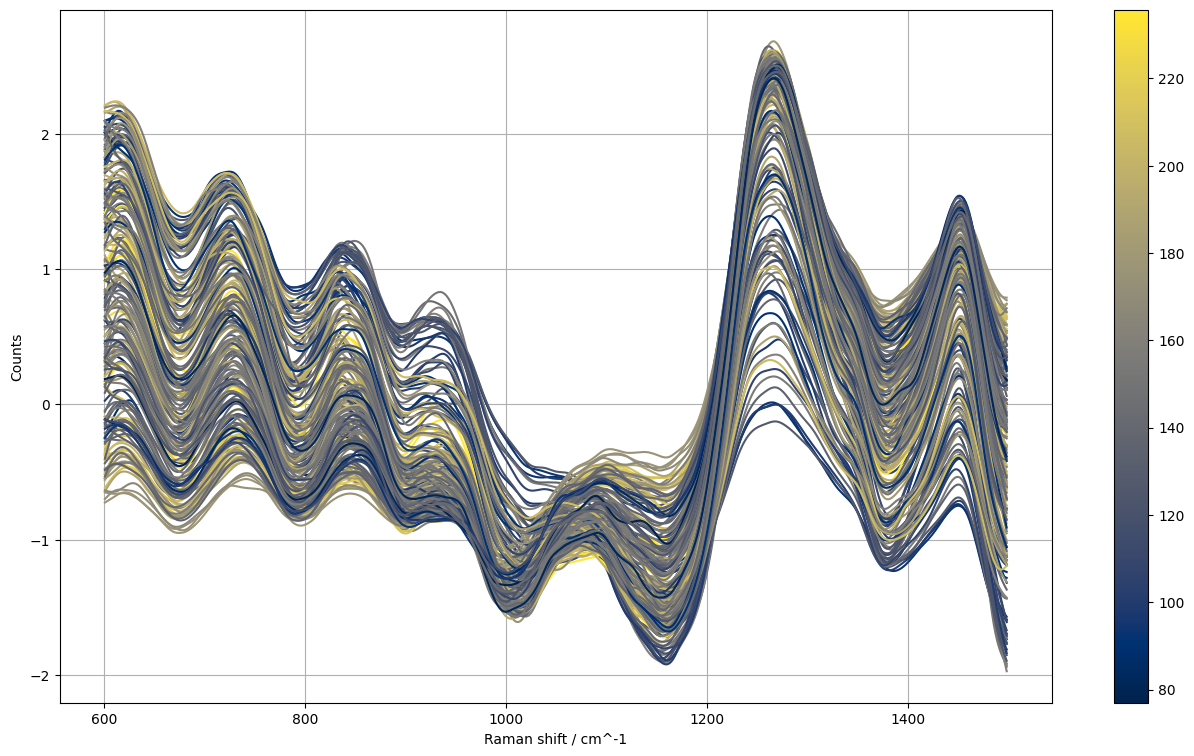

In [11]:
fig,ax = plt.subplots(figsize=(16,9))
ymin = np.inf
ymax = -1 * np.inf
ymin_1125 = np.inf
ymax_1125 = -1 * np.inf
for subj_id, data in zip(subj_ids, datas):
    features = []
    for index,row in data.iterrows():
        glucose = row.glucose
        prefix = row.prefix
        x = row.spectrum[:,0].copy()
        y = row.spectrum[:,1].copy()

        y = preprocessing_4(y)

        # y = preprocessing_2(y)

        color = cMap.to_rgba(glucose)
        ax.plot(x,y, c=color)
        if y.max() > ymax: ymax = y.max()
        if y.min() < ymin: ymin = y.min()
        features.append(y.copy())
    data['feature'] = features

fig.colorbar(cMap, ax=ax)
ax.set_xlabel('Raman shift / cm^-1')
ax.set_ylabel('Counts')
# ax.vlines(x=911, ymax=ymax, ymin=ymin)
# ax.vlines(x=1060, ymax=ymax, ymin=ymin)
# ax.vlines(x=1125, ymax=ymax, ymin=ymin)
# # ax.vlines(x=1265, ymax=ymax, ymin=ymin)
# ax.vlines(x=1450, ymax=ymax, ymin=ymin)

ax.grid()
plt.show()



In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [13]:
y = []
X = []
groups = []
for subj_id, data in zip(subj_ids, datas):
    feature = np.vstack(data.feature.values)
    n, _ = feature.shape
    # y_911 = feature[:, (x > 905) & (x < 915)].mean(axis=1).reshape(n,-1)
    y_911 = feature[:, (x > 905) & (x < 915)]
    # y_1060 = feature[:, (x > 1050) & (x < 1070)].mean(axis=1).reshape(n,-1)
    y_1060 = feature[:, (x > 1050) & (x < 1070)]
    # protien = feature[:, (x > 1440) & (x < 1460)].mean(axis=1).reshape(n,-1)
    protien = feature[:, (x > 1440) & (x < 1460)]
    # sugar = feature[:, (x > 1120) & (x < 1130)].mean(axis=1).reshape(n,-1)
    sugar = feature[:, (x > 1120) & (x < 1130)]
    ratio = (sugar.mean(axis=1) / protien.mean(axis=1)).reshape(n,-1)
    temp = np.hstack([sugar, protien, y_911, y_1060, ratio])
    # print(temp.shape)
    X.append(temp)
    y.append(data.glucose.values)
    if(subj_id in ['s1','s2','s3','s4','s5']):
        groups.append([1] * n)
    else:
        groups.append([2] * n)
X = np.vstack(X)
y = np.hstack(y)
groups = np.hstack(groups)
X.shape, y.shape, groups.shape

((214, 32), (214,), (214,))

In [14]:
def train(modelcls):
    split = RepeatedKFold(n_splits=5, n_repeats=4, random_state=24)
    best_model = None
    best_error = np.infty
    count = 0
    errors = []
    for train, test in split.split(X):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        # Train
        model = None
        if(modelcls == 'mlp'):
            model = MLPRegressor(solver='adam', learning_rate='adaptive', max_iter=100000, hidden_layer_sizes=100, activation='identity')
        else:
            # model = LinearRegression()
            # model = RandomForestRegressor()
            # model = GradientBoostingRegressor()
            # model = AdaBoostRegressor()
            model = modelcls()
        model = model.fit(X_train,y_train.reshape(-1))
        # Test
        y_hat = model.predict(X_test)
        error = mean_squared_error(y_pred=y_hat,y_true=y_test)
        errors.append(error)
        if(best_error > error):
            best_model = model
            best_error = error
        count = count + 1
    return best_model, best_error, np.std(errors)


In [15]:
models = [LinearRegression,
            RandomForestRegressor,
            GradientBoostingRegressor,
            AdaBoostRegressor,
            'mlp']
best_models = []
best_errors = []
stds = []
for model in models:
    best_model, best_error, std = train(model)
    print(best_error)
    best_models.append(best_model)
    best_errors.append(best_error)
    stds.append(std)

962.8165305329454
778.3259842068788
947.4522877314765
731.95425319011
944.9877398393534


In [19]:
model_names = ['LinearRegression','RandomForestRegressor','GradientBoostingRegressor',"AdaBoostRegressor",'MLPRegressor']
for model_name, best_error, best_model, std in zip(model_names, best_errors, best_models, stds):
    print(model_name, best_error, std, sep='\t')

LinearRegression	962.8165305329454	586.94398634756
RandomForestRegressor	778.3259842068788	213.3912206249657
GradientBoostingRegressor	947.4522877314765	220.20605877313272
AdaBoostRegressor	731.95425319011	202.98775290642183
MLPRegressor	944.9877398393534	620.6454196351165


In [62]:
from itertools import product
list(product([0,1,2],[0,1]))

[(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]

(0, 0)
(0, 1)
(1, 0)
(1, 1)
(2, 0)


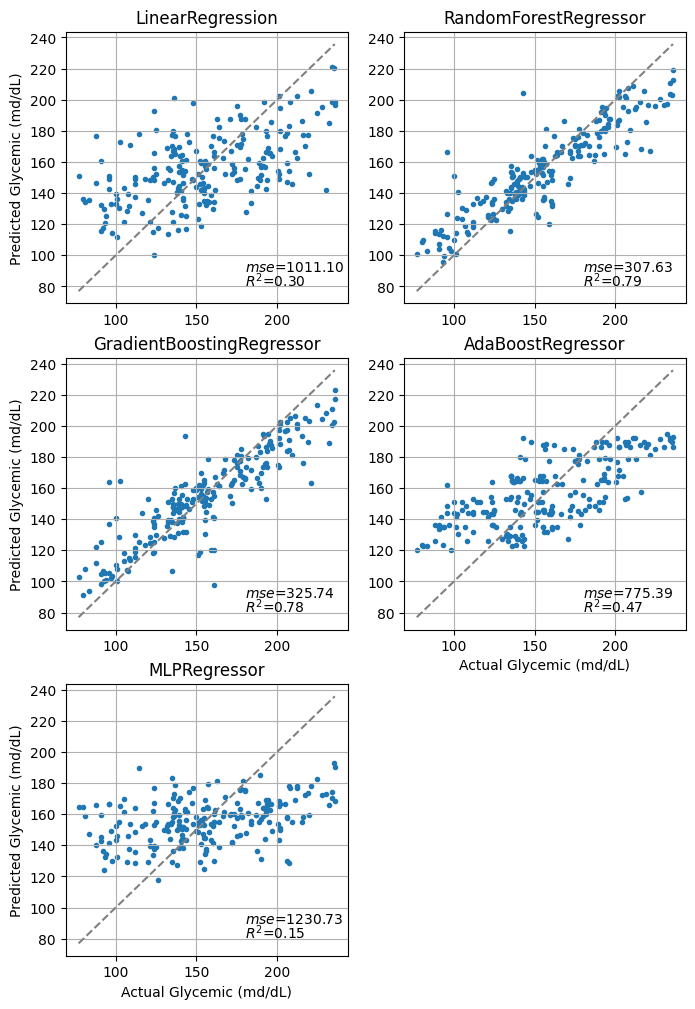

In [65]:
fig,ax = plt.subplots(figsize=(8,12), ncols=2, nrows=3)
for idx, (model_name, model, coord) in enumerate(zip(model_names, best_models, product([0,1,2],[0,1]))):
    print(coord)
    y_hat = model.predict(X)
    # y_scale = scaler.transform(y.reshape(-1,1))
    # print(X.shape, y_hat.shape, y_scale.shape)
    mse = np.round(mean_squared_error(y_pred=y_hat,y_true=y),2)
    r2 = np.round(r2_score(y_pred=y_hat,y_true=y),2)
    ax[coord[0]][coord[1]].scatter(x=y, y=y_hat, marker='.')
    # ax.scatter(x=y[groups == 1], y=y_hat[groups == 1], color='blue', label='old tube')
    # ax.scatter(x=y[groups == 2], y=y_hat[groups == 2], color='red', label='new tube')
    

    min_xy = min(min(y), min(y_hat))
    max_xy = max(max(y), max(y_hat))
    ax[coord[0]][coord[1]].plot([min_xy, max_xy], [min_xy, max_xy], linestyle='--', color='grey')
    ax[coord[0]][coord[1]].text(180,80,s=f'$R^2$={r2:.2f}')
    ax[coord[0]][coord[1]].text(180,90,s=f'$mse$={mse:.2f}')
    if(coord[0] == 2 or (coord[1] == 1 and coord[0] == 1)):
        ax[coord[0]][coord[1]].set_xlabel('Actual Glycemic (md/dL)')
    if(coord[1] == 0):
        ax[coord[0]][coord[1]].set_ylabel('Predicted Glycemic (md/dL)')
    ax[coord[0]][coord[1]].set_title(model_name)
    # ax.legend()
    ax[coord[0]][coord[1]].grid()
fig.delaxes(ax[2][1])
plt.show()

